# Music and AI Summer Term 2020; ANNs and Music (1): Key finding, Tonal pitch profiles

From a computational perspective, determining the tonal center of a given musical piece is a non-trivial task if performed based on note-to-note representations of the given piece alone.

First, let us import some libraries we need in this notebook. Pitchplots is a novel library published by the Digital and Cognitive Musicology Lab at the EPFL, Lausanne (CH) that can be used to visualize phenomena of tonality under a certain framework.

In [1]:
from music21 import *
import numpy as np
from sklearn.utils import shuffle
import pitchplots.static as pps
import pitchplots.parser as ppp
import tensorflow as tf
import keras

Using TensorFlow backend.


To demonstrate, how a pitch class profile of a given musical entity can be visualized, let us first consider a simple C major scale:

In [2]:
cscale = converter.parse('tinyNotation: C D E F G A B c')

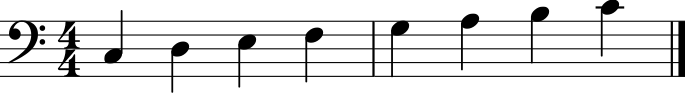

In [3]:
cscale.show()

The following code cells are used to save our stream as a MusicXML file, parse that file using pitchplot's own parser (a variety of the Magenta XML parser) and store the resulting data in a pandas dataframe.

In [4]:
cscale.write('musicXML', fp='cscale.xml')

'/home/sklassmann/material_summerterm20/cscale.xml'

In [5]:
cviz = ppp.xml_to_csv(save_csv=True, filepath='cscale.xml')

The following cells show two possible representations of the parsed pitch profile.

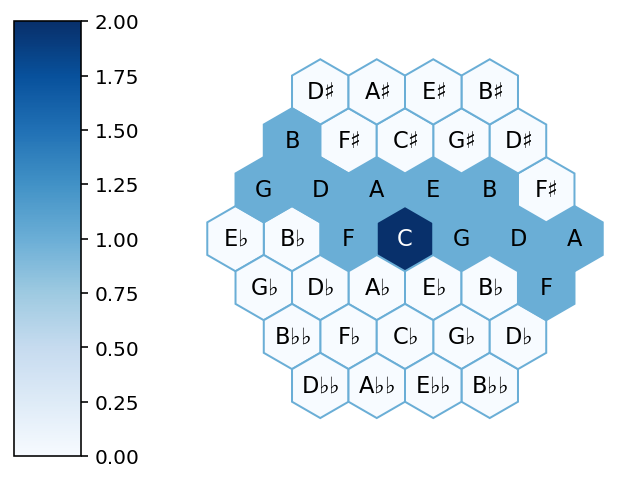

In [6]:
pps.tonnetz(cviz)

As you can see, pitch classes are color coded in relation to their frequency of occurence.

We could of course do the same for a simple children song:

In [7]:
entchen = converter.parse('tinyNotation: C4 D E F G2 G2 A4 A A A G2 A4 A A A G2 F4 F F F E2 E2 D4 D D D C2')

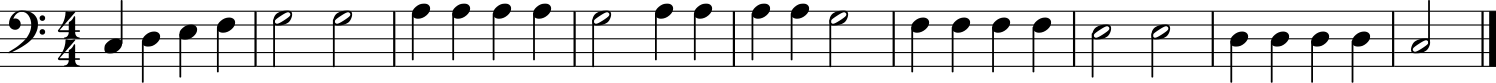

In [8]:
entchen.show()

In [9]:
entchen.write('musicXML', fp='entchen.xml')

'/home/sklassmann/material_summerterm20/entchen.xml'

In [10]:
entchenv = ppp.xml_to_csv(save_csv=True, filepath='entchen.xml')

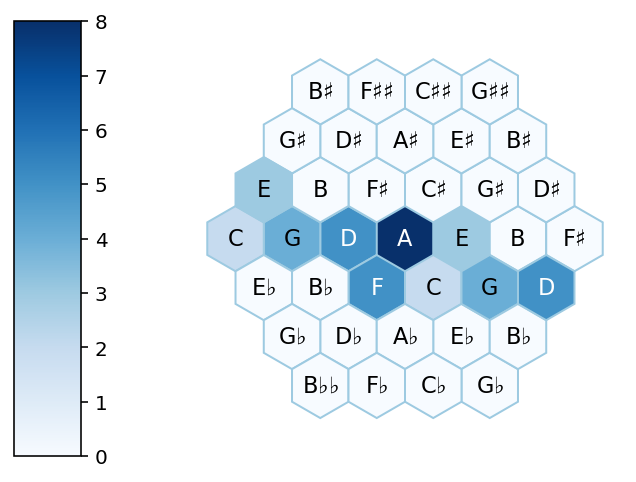

In [11]:
pps.tonnetz(entchenv)

We can ascertain that due to our musical piece only consisting of a monophonic stream of notes, this analysis of our little stream identifies tonal relation purely based on frequencie of occurence of pitch classes. In such, it differs from musical intuition that would suggest a tonal center of C-major for our piece at hand.

This is, of course, a very much simplified example. However, the task of computational tonality detection has been dealt with in various ways. One example model is given by Dawson (2018; chapter 5). We will - for the remainder of this session - analyze an implementation of the ANN architecture applied in this chapter. Please note that we will - for sake of simplicity and due to time constraints - not be using hyperparameters that are identical to the ones proposed by Dawson.

## The task at hand (Dawson 2018, pp. 91-95)

First, let us consider the task posed for our ANN, as well as the desired structure of our dataset.

<img src='architecture.png' width=400>

As before, we want every scale in our dataset to be represented as a single vector containing 12 positions that can either be set to 1 (pitch present) or 0 (pitch not given in scale). We can therefore re-use part of our generator code from the last notebook:

In [12]:
# let us create a basic structure for our entries to work from. We will be working with a list for now
# to keep our data structure more flexible:
bscale = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We can reuse our two functions to modify our basic scale:

In [13]:
def majorize(sc, root):
    sc[root] = 1
    sc[(root + 2)%12] = 1
    sc[(root + 4)%12] = 1
    sc[(root + 5)%12] = 1
    sc[(root + 7)%12] = 1
    sc[(root + 9)%12] = 1
    sc[(root + 11)%12] = 1
    return sc

In [14]:
def minorize(sc, root):
    sc[root] = 1
    sc[(root + 2)%12] = 1
    sc[(root + 3)%12] = 1
    sc[(root + 5)%12] = 1
    sc[(root + 7)%12] = 1
    sc[(root + 8)%12] = 1
    sc[(root + 11)%12] = 1
    return sc

We want to change our labels so that they consist of 1D-arrays encoding both the root of our scale and the mode (major / harmonic minor) of the given scale. Therefore, we will have to start building the labels alongside our training set:

In [15]:
# first, we need to start building our labels as a list of lists:
scalelist=[]
labellist=[]
for i in range(12):
    a = bscale.copy() # work from basic scale vector
    b = majorize(a, i) # majorize it given a root integer that is equal to i.
    scalelist.append(b) # append the vector to our list.
    label = [0] * 13 # initialize our label a list of 13 positions (=0)
    label[i] = 1 # set the position representing the scale root within the label list to 1
    label[-1] = 1 # set the last position of our label to 1, representing a major scale.
    labellist.append(label) # append our label to our list of labels.
# the very same holds for the next loop that does the same in harmonic minor.
for i in range(12):
    a = bscale.copy()
    b = minorize(a, i)
    scalelist.append(b)
    label = [0] * 13 # initialize our label a list of 13 positions (=0)
    label[i] = 1 # set the position representing the scale root within the label list to 1
    label[-1] = 0 # set the last position of our label to 0, representing a harmonic min scale.
    labellist.append(label) # append our label to our list of labels.

In [16]:
scalelist

[[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
 [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
 [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
 [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
 [0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1],
 [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1],
 [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
 [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
 [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]]

In [17]:
labellist

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

That looks good for now. Let us recheck the length of both our lists:

In [18]:
print("we have generated", len(labellist), "label lists.")
print("a single lable is a list consisting of", len(labellist[0]), "positions.")
print("we have generated", len(scalelist), "scales represented as pitch profiles in total.")

we have generated 24 label lists.
a single lable is a list consisting of 13 positions.
we have generated 24 scales represented as pitch profiles in total.


So far, so good.

Let us make some copies of both lists to work with and to name them in a conventional fashion

In [19]:
trainx = list.copy(scalelist)
trainy = list.copy(labellist)

In [20]:
trainx[1], trainy[1]

([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

We can reuse our step to shuffle both sets at the same time:

In [21]:
training_x, training_y = shuffle(np.array(trainx), np.array(trainy))

In [22]:
training_x[0]

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0])

In [23]:
training_y[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Now that we have our training set and labels shuffled correctly, we can start building our model architecture.

Let's take another look at what our architecture should look like:  
<img src='architecture.png' width=400>

As we can see, we will need to create an input layer compatible with our input arrays (12) positions, a hidden layer of four nodes, and an output layer containing 13 nodes to be compatible with our labels.

In [24]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_shape=(12,), activation=tf.nn.relu),  
  tf.keras.layers.Dense(4, activation=tf.nn.relu),
  tf.keras.layers.Dense(13, activation = tf.nn.softmax),
])

Let us compile our model with the same hyperparameters used in our last notebook:

In [25]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

And ultimately, let us start the training process:

In [26]:
model.fit(training_x, training_y, epochs=6801, verbose=0);

In [27]:
model.evaluate(training_x, training_y)

24/24 [==============================] - 0s 6ms/sample - loss: 0.0288 - accuracy: 0.5417


[0.028848832473158836, 0.5416667]

Now, that did not turn out so well, let's try again with a different structure:

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_shape=(12,), activation=tf.nn.relu),  
  tf.keras.layers.Dense(120, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(60, activation=tf.nn.relu), 
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(39, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(26, activation=tf.nn.relu),
  tf.keras.layers.Dense(13, activation = tf.nn.softmax),
])

Let us compile our model with the same hyperparameters used in our last notebook:

In [29]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

And ultimately, let us start the training process:

In [30]:
model.fit(training_x, training_y, epochs=10000, verbose=0);
model.evaluate(training_x, training_y)

24/24 [==============================] - 0s 8ms/sample - loss: 0.0273 - accuracy: 0.6667


[0.02725508250296116, 0.6666667]

Now, that looks slightly better.

----

## Using Pitch Profiles

However, Dawson also proposes a different architecture to solve this task. This one is based on key profiles proposed by Krumhansl & Schmuckler (1990), Albrecht & Shanahan (2013) and Temperley (2007) that grant each of our pitch classes a certain measure of hierarchical importance given a specific tonal center.  
  
Dawson does not use the key profiles as given by the original researchers, but rather adapts them to be suitable for computation within a regular perceptron. (mean-centred normalization in order to prevent negative effects caused by increasing stimulus magnitude)

<img src='profiles.png' width = 500>  
                                                        Dawson (2018), p. 105

As this task is performed by a regular perceptron, we will first have to build our data set. We will once more want to represent 24 different scales by means of vectors containing 11 positions. For today's purposes, we will limit ourselves to the pitch profiles proposed by Temperley (mean-centered, normalized) and create a training and label set for this task. We will then proceed to build a similar architecture in Keras and Tensorflow and train our network using the created data sets.

To start us off, here is the table representing the modified pitch profiles (Temperley) offered by Dawson:

| pitch class | 0     | 1      | 2     | 3      | 4      | 5     | 6      | 7     | 8      | 9      | 10     | 11     |
|-------------|-------|--------|-------|--------|--------|-------|--------|-------|--------|--------|--------|--------|
| major       | 0.442 | -0.330 | 0.151 | -0.305 | 0.355  | 0.119 | -0.289 | 0.405 | -0.280 | 0.014  | -0.333 | 0.052  |
| minor       | 0.423 | -0.308 | 0.146 | 0.313  | -0.348 | 0.130 | -0.283 | 0.463 | 0.064  | -0.327 | -0.251 | -0.022 |

First of all, let us create two lists for the values given above.

In [31]:
plmaj = [0.442, -0.330, 0.151, -0.305, 0.355, 0.119, -0.289, 0.405, -0.280, 0.014, -0.333, 0.052]
plmin = [0.423, -0.308, 0.146, 0.313, -0.348, 0.130, -0.283, 0.463, 0.064, -0.327, -0.251, -0.022]

now, let us try to create 12 lists, shifted for all possible roots:

In [32]:
# we start with two empty lists for labels and pitch profiles
profilelist = []
labellist = []  

# once more, in order to not have to manually enter all values from the above table,
# we start with a list of 0s and modify accordingly.  

label = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] 

In [33]:
# major:
for a in range(12):
    plmajshift = list.copy(plmaj)
    for i in range(len(plmaj)):
        plmajshift[i] = plmaj[(i+12-a)%12]
    profilelist.append(plmajshift)
    labelint = label.copy()
    labelint[a] = 1
    labellist.append(labelint)

In [34]:
# minor:
for a in range(12):
    plminshift = list.copy(plmin)
    for i in range(len(plmin)):
        plminshift[i] = plmin[(i+12-a)%12]
    profilelist.append(plminshift)
    labelint = label.copy()
    labelint[a+12] = 1
    labellist.append(labelint)

Let us briefly check that the profiles were created correctly:

In [35]:
profilestack = np.vstack(profilelist)

In [36]:
profilestack

array([[ 0.442, -0.33 ,  0.151, -0.305,  0.355,  0.119, -0.289,  0.405,
        -0.28 ,  0.014, -0.333,  0.052],
       [ 0.052,  0.442, -0.33 ,  0.151, -0.305,  0.355,  0.119, -0.289,
         0.405, -0.28 ,  0.014, -0.333],
       [-0.333,  0.052,  0.442, -0.33 ,  0.151, -0.305,  0.355,  0.119,
        -0.289,  0.405, -0.28 ,  0.014],
       [ 0.014, -0.333,  0.052,  0.442, -0.33 ,  0.151, -0.305,  0.355,
         0.119, -0.289,  0.405, -0.28 ],
       [-0.28 ,  0.014, -0.333,  0.052,  0.442, -0.33 ,  0.151, -0.305,
         0.355,  0.119, -0.289,  0.405],
       [ 0.405, -0.28 ,  0.014, -0.333,  0.052,  0.442, -0.33 ,  0.151,
        -0.305,  0.355,  0.119, -0.289],
       [-0.289,  0.405, -0.28 ,  0.014, -0.333,  0.052,  0.442, -0.33 ,
         0.151, -0.305,  0.355,  0.119],
       [ 0.119, -0.289,  0.405, -0.28 ,  0.014, -0.333,  0.052,  0.442,
        -0.33 ,  0.151, -0.305,  0.355],
       [ 0.355,  0.119, -0.289,  0.405, -0.28 ,  0.014, -0.333,  0.052,
         0.442, -0.33 , 

So far, so good. Now we once more have a training set as list of lists and a label list as a list of lists. Therefore, we can shuffle them as before:

In [37]:
trainx = list.copy(profilelist)
trainy = list.copy(labellist)

In [38]:
trainx[0], trainy[0]

([0.442,
  -0.33,
  0.151,
  -0.305,
  0.355,
  0.119,
  -0.289,
  0.405,
  -0.28,
  0.014,
  -0.333,
  0.052],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We can reuse our step to shuffle both sets at the same time:

In [39]:
trainy

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
training_x, training_y = shuffle(np.array(trainx), np.array(trainy))

Let's quickly check one of our shuffled examples:

In [41]:
training_x[19], training_y[19]

(array([ 0.119, -0.289,  0.405, -0.28 ,  0.014, -0.333,  0.052,  0.442,
        -0.33 ,  0.151, -0.305,  0.355]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]))

-----

Let's **build** our model:

In [42]:
temperley = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_shape=(12,), activation=tf.nn.relu),
  tf.keras.layers.Dense(24, activation = tf.nn.sigmoid),
])

Let us **compile** our model:

In [43]:
temperley.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

And ultimately, let us start the training process, i.e. **fit** our model to the training data given a set number of training epochs and **evaluate** it's performance over the training data:

In [44]:
temperley.fit(training_x, training_y, epochs=2500, verbose = 0);
temperley.evaluate(training_x, training_y)

24/24 [==============================] - 0s 7ms/sample - loss: 0.0034 - accuracy: 1.0000


[0.003428490599617362, 1.0]

Let us verify it worked:

In [45]:
for i in range(1):
    training_x, training_y = shuffle(np.array(trainx), np.array(trainy))
    print(training_x[0], training_y[0])
    temperley.evaluate(training_x, training_y)

[-0.28   0.014 -0.333  0.052  0.442 -0.33   0.151 -0.305  0.355  0.119
 -0.289  0.405] [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24/24 [==============================] - 0s 160us/sample - loss: 0.0034 - accuracy: 1.0000


That verifies that the model is now able to classify the training set correctly, independent of order.

------

### Summary:

As we have seen, implementing a tensorflow / keras model to solve a given task, we need to consider the following basic steps for now:  
  
**Problem Description $\rightarrow$ Data Preprocessing $\rightarrow$ Build $\rightarrow$ Compile $\rightarrow$ Fit $\rightarrow$ Evaluate**

-----

## Using our trained ANN to classify the key of a given piece from the music21 corpus

Now, what can we do with our trained model?  
  
One idea might be:  
  
As our model was trained using pitch profiles that have been derived from larger corpora of music, could it also be used to predict the key of an unseen musical example?

----

Now we will need a preprocessed example to use. Let us try using absolute frequency of occurence for all pitch classes:

In [46]:
bac = corpus.parse('bach/bwv27') # parse a musical composition from the music21 corpus

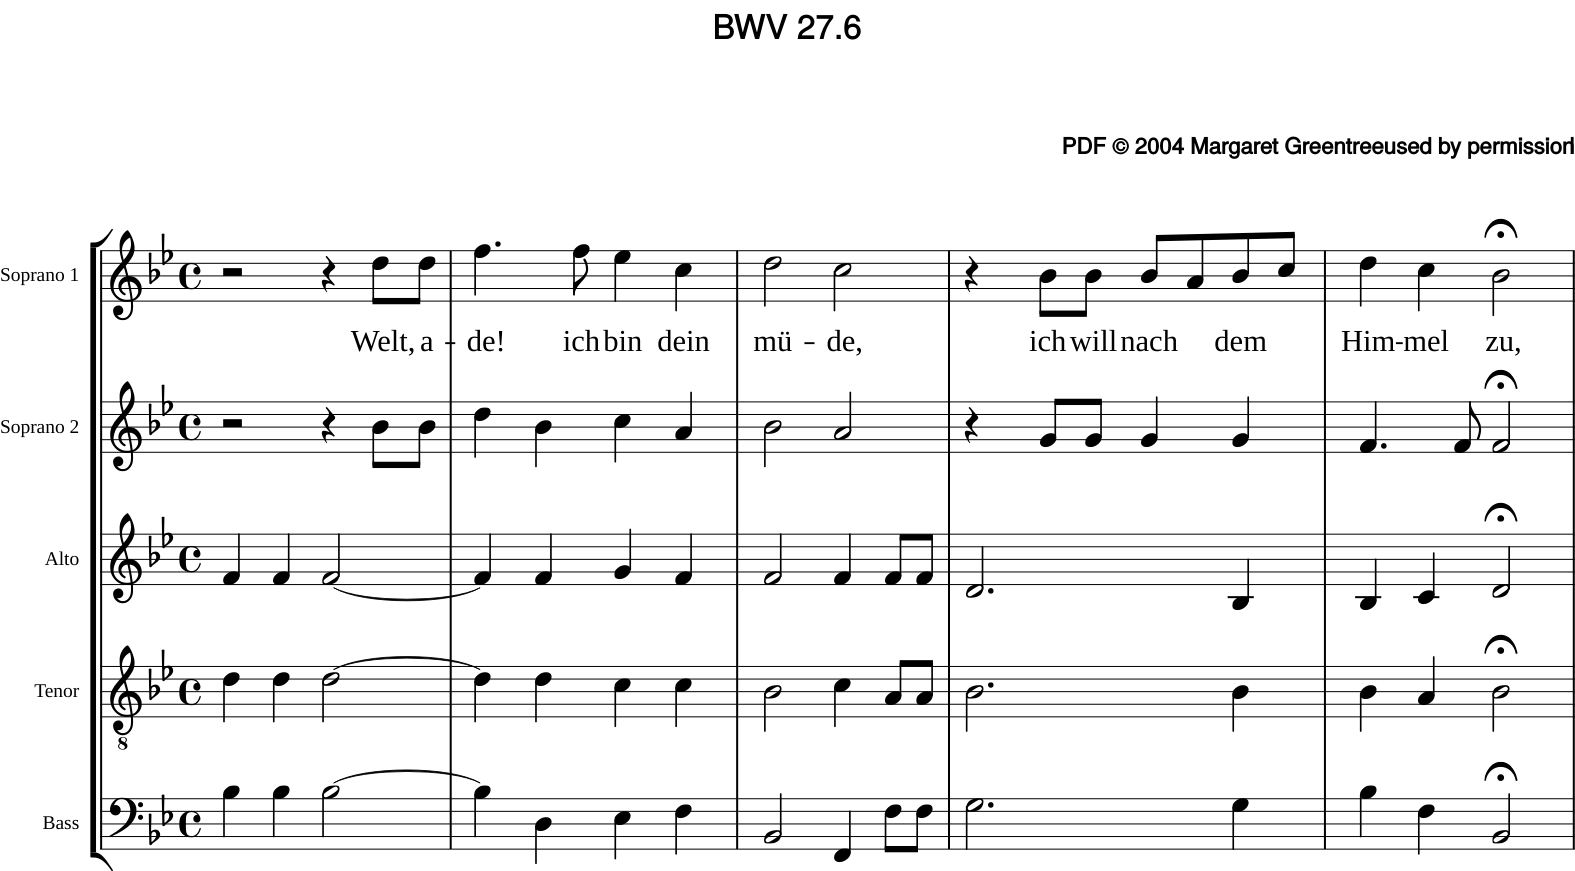

In [47]:
bac.show() # let's have a look at the piece in question!

Now we need a **converter** in order to convert a music21 stream into an array containing the frequency of occurrence for all 12 pitch classes. First we want an array of 0s to start from.

In [48]:
anlist = np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

Our converter will use music21's .recurse() to filter a given stream for note.Note objects, analyze their midi pitch (%12 for octave independence) and modify the respective position in our array.

In [49]:
for p in bac.recurse().getElementsByClass(note.Note):
    # print(p.pitch.midi)
    anlist[p.pitch.midi % 12] += 1
print("result of music21 analysis:", bac.analyze('key')) # predicted key using music21's own key analyzer (a variant of Krummhansl-Schmuckler)

result of music21 analysis: B- major


In [50]:
# technically, we need to transpose our array in order to work with our trained model:
lllist = []
lllist.append(anlist.T)
lllist

[array([[35,  2, 55, 12,  8, 62,  2, 28,  0, 33, 60,  0]])]

In [51]:
prediction = temperley.predict(lllist)

What does that give us?

In [52]:
print(prediction)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 6.7692475e-26 0.0000000e+00
  9.9954551e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 5.0781814e-32 0.0000000e+00]]


In [53]:
np.argmax(prediction)

10

This tells us that the highes predicted probability for a label is to be found at the 10th position of our prediction array. As we encoded the frequency vector using C=0, this refers to the 10th major key in our case, which would be Bb / A# major, which aligns quite well with music21's own analysis.

----

<img src='https://cdn.pixabay.com/photo/2016/03/04/19/36/beach-1236581_1280.jpg' width = 700>

#### Thank you very much for today!

----

## References:  
 
Albrecht, J. D., & Shanahan, D. (2013). The use of large corpora to train a new type of key-finding algorithm: An improved treatment of the minor mode. *Music Perception, 31*(1), 59–67. doi: 10.1525/mp.2013.31.1.59  
  
Dawson, M. (2018). *Connectionist Representations of Tonal Music. Discovering Musical Patterns by Interpreting Artificial Neural Networks.* Edmonton, AU Press.
  
Krumhansl, C. L. (1990). *Cognitive foundations of musical pitch*. New York, NY: Oxford
University Press.   
  
Moss, Fabian C.; Loayza, Timothy & Rohrmeier Martin. (2019). pitchplots (Version 1.4.2). Zenodo. http://doi.org/10.5281/zenodo.3265393
   
Temperley, D. (2007). *Music and probability*. Cambridge, MA: MIT Press.  
  
Temperley, D. (2004). Bayesian models of musical structure and cognition. *Musicae
Scientiae, 8*(2), 175–205.
  
